**Author**: Justine Debelius<br>
**email**: jdebelius@ucsd.edu<br>
**enviroment**: agp_2017<br>
**Date**: 16 May 2017

This notebook will build a linear regression comparing the alpha diversity of participants in the American Gut to covariates fo interest.

We're going to focus on a subset of the participants. Namely, we're going to look at individuals living in the US and UK with a BMI of less than 40.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy
import skbio
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
map_ = pd.read_csv('./03.packaged/5000/ag_map_with_alpha.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

map_.replace('Unspecified', np.nan, inplace=True)

In [3]:
map_['faiths_pd_5000'] = map_['faiths_pd_5000'].astype(float)

In [4]:
map_['age_corrected'] = map_['age_corrected'].astype(float)
map_.loc[map_['age_corrected'] > 105, 'age_corrected'] = np.nan

map_['bmi_corrected'] = map_['bmi_corrected'].astype(float)

We're going to only look at samples from the US and UK, since these represent about 92% of the samples in the data set.

In [13]:
def filter_map(x):
    country = x['country'] in {'USA', 'United Kingdom', 'Canada'}
    bmi = (x['bmi_corrected'] < 40) and (pd.isnull(x['bmi_corrected']) == False)
    sex = x['sex'] in {'male', 'female'}
    poo = x['bowel_movement_quality'] not in {"I don't know, I do not have a point of reference"}
    race = x['race'] in {'Caucasian', 'Asian or Pacific Islander', 'Other'}
    cpn = x['center_project_name'] in {'AG1', 'AG11', 'AG13', 'AG14', 'AG17', 'AG18', 
                                       'AG19', 'AG2', 'AG20', 'AG3', 'AG4', 'AG5', 
                                       'AG6', 'AG7', 'AG9', 'AGFermentation', 
                                       'AGUNDX', 'AGagOffice1', 'AGlost_samples'}
    return country & bmi & sex & poo & race & cpn

To address `country_of_birth`, we'll first try binning into a category we'll call "immigration". This will indicate whether the country of birth and the reported country match. (We'd use country of residence, but that was introduced far later).

In [14]:
study_columns = [
    'center_project_name',
    'age_corrected', 
    'age_cat',
    'alcohol_frequency', 
    'antibiotic_history',
    'bmi_corrected', 
    'bowel_movement_quality', 
    'ibd', 
    'ibs',
    'country', 
    'race', 
    'types_of_plants',
    'sex', 
    'sleep_duration', 
    'faiths_pd_5000',
    'chickenpox',
    ]

In [15]:
fmap_ = map_.loc[map_.apply(filter_map, axis=1)]
smap_ = fmap_[study_columns].dropna()

We're going to do some additional clean up, to make life easier? 

So, we'll combine the self diagnosed or alternative medicate practioner diagnosis into a `non medical diagnosis` category. This allows us to keep the individuals, but combines the groups.

We'll rename the alcohol frequency, antibiotic history, bowel movement quality, and to make them prettier in the regression.<br>
We'll also combine people who took antibiotics in the last week and the last month, since the last week is also part of the last month.<br>
We'll also combine the sleep durations of less than 6 hours (Less than 5 and 5 - 6).



We're going to code the data using numeric codeing, since this will be easier for patsy to handle.
We'll also do some work to build combinations.

We're going to combine the antibiotics in the last week and in the last month. <br>
For both IBD and IBS, we will combine people who were idagnosed by an alternative medicine practioner or self diagnosed individuals into a different category.

In [8]:
smap_['center_project_name'].value_counts()

AGag35             225
AG31               200
AGag36             196
AGag34             193
AGAGA.RR           191
AG27               184
AGag33             165
AGp.109.110.111    117
AGagFerm           117
AG3dMouse           73
AG29                62
AG30                49
AG25                48
AG10                27
AGagSurfers         27
AG8                 22
AG28                22
AG17                12
AG13                11
AG14                10
AG1                 10
AG2                  9
AG7                  9
AG5                  9
AG11                 8
AG18                 6
AG4                  5
AGUNDX               5
AGFermentation       5
AG6                  4
AG3                  4
AG19                 3
AG20                 2
AG9                  2
AGlost_samples       1
AGagOffice1          1
Name: center_project_name, dtype: int64

In [9]:
numeric_coding = {'alcohol_frequency': {'Never': 0,
                                        'Rarely (a few times/month)': 1,
                                        'Occasionally (1-2 times/week)': 2,
                                        'Regularly (3-5 times/week)': 3,
                                        'Daily': 4,
                                        },
                  'antibiotic_history': {'I have not taken antibiotics in the past year.': 0,
                                         'Year': 1,
                                         '6 months': 2,
                                         'Month': 3,
                                         'Week': 3,
                                         },
                  'bowel_movement_quality': {'I tend to have normal formed stool': 0,
                                             'I tend to have diarrhea (watery stool)': 1,
                                             'I tend to be constipated (have difficulty passing stool)': 2,
                                             },
                  'chickenpox': {'No': 0,
                                 'Yes': 1,
                                 'Not sure': 2
                                },
                  'country': {'USA': 0,
                              'United Kingdom': 1,
                              'Canada': 2,
                              'Australia': 3,
                              },
                  'ibd': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'ibs': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'race': {"Caucasian": 0,
                           'Asian or Pacific Islander': 1,
                           'Other': 2,
                           },
                  'sex': {'female': 0, 
                          'male': 1},
                  'sleep_duration': {'Less than 5 hours': 0,
                                     '5-6 hours': 0,
                                     '6-7 hours': 1,
                                     '7-8 hours': 2,
                                     '8 or more hours': 3,
                                     },
                  'types_of_plants': {'Less than 5': 0,
                                      '6 to 10': 1,
                                      '11 to 20': 2,
                                      '21 to 30': 3,
                                      'More than 30': 4,
                                      },
                  }

In [16]:
smap_['age_corrected'].to_clipboard()

In [10]:
smap_numeric = smap_.replace(numeric_coding)

In [ ]:
smap_numeric.to_csv('')

In [25]:
smap_numeric.shape

(2034, 15)

In [26]:
smap_numeric['ln_age'] = np.log(smap_numeric['age_corrected'] + 1)

In [27]:
smap_numeric.to_csv('./coded_regression_map_5k.txt', sep='\t', index_label='#SampleID')

In [28]:
!pwd

/Users/jdebelius/AmericanGut/2017/04.paper/01.justine_packaging


Next, we'll build a regression including the covariate we're potentially interested in.

Next, we'll build a function that will let us preform a step-wise selection based on a decrease in the AIC, an increase in the adjusted $R^{2}$ and not blowing up the condition number.

In [ ]:
def build_function(continous, categorical, response='faiths_pd_5000'):

In [68]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     73.38
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.69e-31
Time:                        11:45:14   Log-Likelihood:                -6012.4
No. Observations:                2034   AIC:                         1.203e+04
Df Residuals:                    2031   BIC:                         1.205e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          16.9185      0.137    1

In [69]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     42.22
Date:                Tue, 23 May 2017   Prob (F-statistic):           4.72e-34
Time:                        11:45:17   Log-Likelihood:                -6002.1
No. Observations:                2034   AIC:                         1.201e+04
Df Residuals:                    2029   BIC:                         1.204e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          17.0163      0.138    1

In [70]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     30.85
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.28e-35
Time:                        11:45:19   Log-Likelihood:                -5994.5
No. Observations:                2034   AIC:                         1.200e+04
Df Residuals:                    2027   BIC:                         1.204e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          17.1602      0.142    1

In [71]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + C(antibiotic_history)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     25.59
Date:                Tue, 23 May 2017   Prob (F-statistic):           4.41e-42
Time:                        11:45:19   Log-Likelihood:                -5973.8
No. Observations:                2034   AIC:                         1.197e+04
Df Residuals:                    2024   BIC:                         1.202e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [72]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + C(race)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     34.63
Date:                Tue, 23 May 2017   Prob (F-statistic):           2.87e-57
Time:                        11:45:20   Log-Likelihood:                -5937.7
No. Observations:                2034   AIC:                         1.190e+04
Df Residuals:                    2024   BIC:                         1.195e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             17.8799      0

In [78]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + age_corrected', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     38.62
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.51e-57
Time:                        11:54:00   Log-Likelihood:                -5939.0
No. Observations:                2034   AIC:                         1.190e+04
Df Residuals:                    2025   BIC:                         1.195e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             14.9656      0

/Users/jdebelius/miniconda2/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


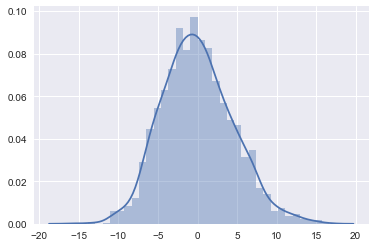

In [79]:
sn.distplot(fit1.resid)

In [80]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     38.78
Date:                Tue, 23 May 2017   Prob (F-statistic):           8.62e-58
Time:                        11:54:04   Log-Likelihood:                -5938.4
No. Observations:                2034   AIC:                         1.189e+04
Df Residuals:                    2025   BIC:                         1.195e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.2472      1

/Users/jdebelius/miniconda2/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


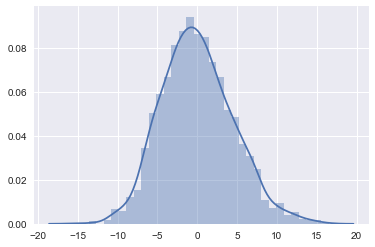

In [81]:
sn.distplot(fit1.resid)

In [77]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age'
               '+ C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     36.59
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.64e-60
Time:                        11:53:52   Log-Likelihood:                -5930.1
No. Observations:                2034   AIC:                         1.188e+04
Df Residuals:                    2024   BIC:                         1.194e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.5873      1

In [82]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age*C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     34.04
Date:                Tue, 23 May 2017   Prob (F-statistic):           9.16e-62
Time:                        11:57:15   Log-Likelihood:                -5925.2
No. Observations:                2034   AIC:                         1.187e+04
Df Residuals:                    2023   BIC:                         1.193e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             11.7623      1

In [83]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age*C(sex)'
               '+ types_of_plants', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     33.99
Date:                Tue, 23 May 2017   Prob (F-statistic):           4.86e-67
Time:                        11:58:59   Log-Likelihood:                -5910.8
No. Observations:                2034   AIC:                         1.185e+04
Df Residuals:                    2022   BIC:                         1.191e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             11.1217      1

In [86]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country)*C(sex) + C(ibd) + C(ibs) + antibiotic_history + ln_age'
               '+ types_of_plants', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     30.13
Date:                Tue, 23 May 2017   Prob (F-statistic):           4.42e-64
Time:                        12:02:49   Log-Likelihood:                -5916.0
No. Observations:                2034   AIC:                         1.186e+04
Df Residuals:                    2021   BIC:                         1.193e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [87]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country)*C(sex) + C(ibd) + C(ibs) + antibiotic_history + ln_age'
               '+ C(types_of_plants)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     24.10
Date:                Tue, 23 May 2017   Prob (F-statistic):           5.49e-62
Time:                        12:03:02   Log-Likelihood:                -5915.8
No. Observations:                2034   AIC:                         1.186e+04
Df Residuals:                    2018   BIC:                         1.195e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

In [89]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + age_corrected*C(sex)'
               ' + types_of_plants + C(race)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     33.39
Date:                Tue, 23 May 2017   Prob (F-statistic):           3.65e-76
Time:                        12:03:30   Log-Likelihood:                -5885.4
No. Observations:                2034   AIC:                         1.180e+04
Df Residuals:                    2020   BIC:                         1.188e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

In [23]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + age_corrected*C(sex)'
               ' + (types_of_plants) + sleep_duration', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     32.61
Date:                Tue, 23 May 2017   Prob (F-statistic):           1.37e-69
Time:                        11:16:05   Log-Likelihood:                -6092.4
No. Observations:                2100   AIC:                         1.221e+04
Df Residuals:                    2087   BIC:                         1.228e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

In [24]:
fit1 = smf.ols('faiths_pd_5000 ~ C(country) + C(ibd) + C(ibs) + antibiotic_history + age_corrected*C(sex)'
               ' + (types_of_plants) + C(sleep_duration)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_5000   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     28.03
Date:                Tue, 23 May 2017   Prob (F-statistic):           2.53e-68
Time:                        11:16:15   Log-Likelihood:                -6091.8
No. Observations:                2100   AIC:                         1.221e+04
Df Residuals:                    2085   BIC:                         1.230e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             